# Building Pipeline

## Introduction
[Kubeflow Pipelines](https://www.kubeflow.org/docs/pipelines/) helps with building entire workflows

These steps can be triggered automatically by a CI/CD workflow or on demand from a command line or notebook.


**Components** performs a single step in a Machine Learning workflow such (e.g. data ingestion, data preprocessing, data transformation, model training, hyperparameter tuning).

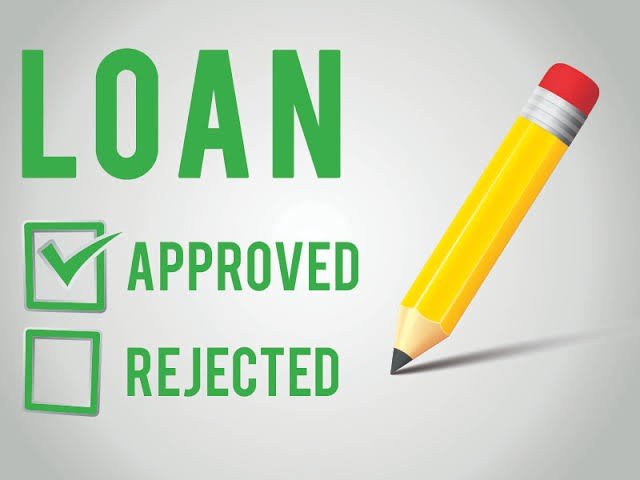

## Prerequisites
check to see if kfp is installed:

In [ ]:
! pip3 show kfp

## Configure access Minio

### Upload our Training Dataset to Minio

First, we configure credentials for `mc`, the MinIO command line client.
We then use it to create a bucket, upload the dataset to it, and set access policy so that the pipeline can download it from MinIO.

Follow the steps below to download minio client
<div class="alert">
   <code>
    wget https://dl.min.io/client/mc/release/linux-amd64/mc
    chmod +x mc
    ./mc --help
    </code>

</div>




In [ ]:
! wget https://dl.min.io/client/mc/release/linux-amd64/mc
! chmod +x mc
! ./mc --help

#### a. Connect to the Minio Server

In [ ]:
! ./mc alias set minio http://minio-service.kubeflow:9000 minio minio123

#### b. Create a bucket to store your data and export your model to Minio

**Make sure you clear this bucket once you are cone running your pipeline**

In [ ]:
 ! ./mc mb minio/loan

In [ ]:
! ./mc ls minio mlpipeline

#### c. Upload the dataset to your bucket in Minio.

**Note**: Make sure you have your dataset in a folder like we have here as <code>datasets</code>.

In [ ]:
! tar --dereference -czf datasets.tar.gz ./datasets
! ./mc cp datasets.tar.gz minio/loan/datasets.tar.gz
! ./mc policy set download minio/loan

### If you have downloaded your data too many times while testing, use the following code to clear out your bucket

In [ ]:
# ! ./mc rm --recursive --force minio/loan

### Minio Server URL and Credentials

In [ ]:
MINIO_SERVER='minio-service.kubeflow:9000'
MINIO_ACCESS_KEY='minio'
MINIO_SECRET_KEY='minio123'

## How to Implement Kubeflow Pipelines Components

In this pipeline, we have the following components:
- Loan dataset download component
- Preprocess the dataset component
- Train the model component
- Test the model component
- Export the trained model component

In [ ]:
from typing import NamedTuple
import kfp
import kfp.components as components
import kfp.dsl as dsl
from kfp.components import InputPath, OutputPath #helps define the input & output between the components

### Component 1: Download the Data Set

In [ ]:
def download_dataset(data_dir: OutputPath(str), minio_server: str):
    """Download the data set to the KFP volume to share it among all steps"""
    import urllib.request
    import tarfile
    import os
    import subprocess

    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
        
    url = f'http://{minio_server}/loan/datasets.tar.gz'
    stream = urllib.request.urlopen(url)
    tar = tarfile.open(fileobj=stream, mode="r|gz")
    tar.extractall(path=data_dir)
    
    subprocess.call(["pwd", data_dir])
    subprocess.call(["ls", "-dlha", data_dir])

### Component 2: Preprocess the DataSet

In [ ]:
def preprocessing(data_dir: InputPath(str), clean_data_dir: OutputPath(str)):
    
    import sys, subprocess;
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'joblib'])
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'pandas'])
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'sklearn'])
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'imblearn'])
#     subprocess.run([sys.executable, '-m', 'pip', 'install', 'os'])

    subprocess.call(["ls", "-dlha", data_dir])
    
    import joblib
    import numpy as np
    import pandas as pd
    from sklearn import preprocessing
    from sklearn.model_selection import train_test_split
    import re
    import os
    import pickle
    from imblearn.over_sampling import SMOTE
    
    subprocess.call(["ls", "-dlha", f'{data_dir}/datasets/data.csv'])
    
    df = pd.read_csv(f'{data_dir}/datasets/data.csv')

    df =df.dropna(axis = 0 , how = 'any')

    def age(dob):
        yr = int(dob[-2:])  
        if yr >=0 and yr < 20:
            return yr + 2000
        else:
            return yr + 1900

    df['Date.of.Birth'] = df['Date.of.Birth'].apply(age)
    df['DisbursalDate'] = df['DisbursalDate'].apply(age)

    df['Age'] = df['DisbursalDate'] - df['Date.of.Birth']
    df = df.drop( ['DisbursalDate', 'Date.of.Birth'], axis=1)

    df['AVERAGE.ACCT.AGE_yrs'] = df['AVERAGE.ACCT.AGE'].apply(lambda x: re.search(r'\d+(?=yrs)', x).group(0)).astype(np.int)
    df['AVERAGE.ACCT.AGE_mon'] = df['AVERAGE.ACCT.AGE'].apply(lambda x: re.search(r'\d+(?=mon)', x).group(0)).astype(np.int)
    df = df.drop('AVERAGE.ACCT.AGE', axis=1)

    df['CREDIT.HISTORY.LENGTH_yrs'] = df['CREDIT.HISTORY.LENGTH'].apply(lambda x: re.search(r'\d+(?=yrs)', x).group(0)).astype(np.int)
    df['CREDIT.HISTORY.LENGTH_mon'] = df['CREDIT.HISTORY.LENGTH'].apply(lambda x: re.search(r'\d+(?=mon)', x).group(0)).astype(np.int)
    df = df.drop('CREDIT.HISTORY.LENGTH', axis=1)
    pri_columns = ['PRI.NO.OF.ACCTS','SEC.NO.OF.ACCTS',
            'PRI.ACTIVE.ACCTS','SEC.ACTIVE.ACCTS',
            'PRI.OVERDUE.ACCTS','SEC.OVERDUE.ACCTS',
            'PRI.CURRENT.BALANCE','SEC.CURRENT.BALANCE',
            'PRI.SANCTIONED.AMOUNT','SEC.SANCTIONED.AMOUNT',
            'PRI.DISBURSED.AMOUNT','SEC.DISBURSED.AMOUNT',
            'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT']

    #Creating and Sorting Columns

    df['NO_OF_ACCTS'] = df['PRI.NO.OF.ACCTS'] + df['SEC.NO.OF.ACCTS']

    df['ACTIVE_ACCTS'] = df['PRI.ACTIVE.ACCTS'] + df['SEC.ACTIVE.ACCTS']

    df['OVERDUE_ACCTS'] = df['PRI.OVERDUE.ACCTS'] + df['SEC.OVERDUE.ACCTS']

    df['CURRENT_BALANCE'] = df['PRI.CURRENT.BALANCE'] + df['SEC.CURRENT.BALANCE']

    df['SANCTIONED_AMOUNT'] = df['PRI.SANCTIONED.AMOUNT'] + df['SEC.SANCTIONED.AMOUNT']

    df['Total_AMOUNT'] = df['PRI.DISBURSED.AMOUNT'] + df['SEC.DISBURSED.AMOUNT']

    df['INSTAL_AMT'] = df['PRIMARY.INSTAL.AMT'] + df['SEC.SANCTIONED.AMOUNT']

    df['INACTIVE_ACCTS'] = df['NO_OF_ACCTS'] - df['ACTIVE_ACCTS']

    df.drop(pri_columns, axis=1, inplace=True)


    columns_unique = ['UniqueID','MobileNo_Avl_Flag',
          'Current_pincode_ID','Employee_code_ID',
          'NO.OF_INQUIRIES','State_ID',
          'branch_id','manufacturer_id','supplier_id', 'Driving_flag',	'Passport_flag']
    df = df.drop(columns=columns_unique)

    objects = df.select_dtypes('object').columns.tolist()
    le = preprocessing.LabelEncoder()
    df[objects] = df[objects].apply(le.fit_transform) 

    X = df.drop(['loan_default'], axis=1)
    y = df['loan_default']

    scaler = preprocessing.RobustScaler()
    X = scaler.fit_transform(X)


    # Split the data into training and testing sets 
    x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = .3, random_state = 33)


    sm = SMOTE(random_state=2)
    x_train, y_train = sm.fit_resample(x_train, y_train.ravel())

    data = {"X_train": x_train,"X_test": x_test, "Y_train": y_train,"Y_test": y_test}

#     joblib.dump(data,'clean_data')
    os.makedirs(clean_data_dir, exist_ok=True)

    with open(os.path.join(clean_data_dir,'clean_data.pickle'), 'wb') as f:
        pickle.dump(data, f)
    
    print(f"clean_data.pickle {clean_data_dir}")
    
    print(os.listdir(clean_data_dir))


### Component 3: Train the model

In [ ]:

def train_model(clean_data_dir: InputPath(str), model_dir: OutputPath(str)):
    import sys, subprocess;
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'joblib'])
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'sklearn'])
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'pandas'])
    import joblib
    import os
    import pickle
    from sklearn.ensemble import GradientBoostingClassifier

    print(clean_data_dir)
    with open(os.path.join(clean_data_dir,'clean_data.pickle'), 'rb') as f:
        data = pickle.load(f)
        
    print(data)   
    
    x_train = data['X_train']
    y_train = data['Y_train']

    gbc = GradientBoostingClassifier(n_estimators=8, min_samples_split=5, max_depth=15, verbose = 1)
    
    # Fitting model
    model = gbc.fit(x_train, y_train)
    
    os.makedirs(model_dir, exist_ok=True)
    
    with open(os.path.join(model_dir,'model.pickle'), 'wb') as f:
        pickle.dump(model, f)
    
    print(f"model.pickle {model_dir}")
    
    print(os.listdir(model_dir))
    

### Component 4: Test Model

In [ ]:
def test_model(
    clean_data_dir: InputPath(str), model_dir: InputPath(str), metrics_path: OutputPath(str)
) -> NamedTuple("EvaluationOutput", [("mlpipeline_metrics", "Metrics")]):
    import sys, subprocess;
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'joblib'])
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'sklearn'])
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'pandas'])
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.metrics import roc_auc_score,accuracy_score,precision_score,recall_score,f1_score
    from sklearn.metrics import confusion_matrix, roc_curve, auc
    import numpy as np
    import json
    import os
    import pandas as pd
    import joblib
    import pickle
    from collections import namedtuple
    
    print(model_dir)
    with open(os.path.join(model_dir,'model.pickle'), 'rb') as f:
        model = pickle.load(f)
        
    print(model)
    
    print(clean_data_dir)
    with open(os.path.join(clean_data_dir,'clean_data.pickle'), 'rb') as f:
        data = pickle.load(f)
        
    print(data)


    x_test = data['X_test']
    y_test = data['Y_test']

    pred = model.predict(x_test)
    #Model accuracy
    accuracy = accuracy_score(y_test, pred)*100

    precision = precision_score(y_test, pred)*100
    recall = recall_score(y_test, pred)*100
    f1 = f1_score(y_test, pred)*100


    #ROC Score
    roc_score = roc_auc_score(y_test, pred)*100

    # Confusion matrix
    confusion = pd.DataFrame(confusion_matrix(y_test, pred))

    #ROC Score
    fpr, tpr, threshold = roc_curve(y_test, pred)
    roc_auc = auc(fpr, tpr)*100
    
    metrics = {
        "metrics": [
            {"name": "accuracy", "numberValue": str(accuracy), "format": "PERCENTAGE"},
            {"name": "precision", "numberValue": str(precision), "format": "PERCENTAGE"},
            {"name": "recall", "numberValue": str(recall), "format": "PERCENTAGE"},
            {"name": "f1", "numberValue": str(f1), "format": "PERCENTAGE"},
            {"name": "roc_score", "numberValue": str(roc_score), "format": "PERCENTAGE"},
            {"name": "confusion", "numberValue": str(confusion), "format": "PERCENTAGE"},
            {"name": "roc_auc", "numberValue": str(roc_auc), "format": "PERCENTAGE"}
            
        ]
    }

    with open(metrics_path, "w") as f:
        json.dump(metrics, f)

    out_tuple = namedtuple("EvaluationOutput", ["mlpipeline_metrics"])

    return out_tuple(json.dumps(metrics))


### Component 5: Export Model

In [ ]:
def export_model(
    model_dir: InputPath(str),
    metrics: InputPath(str),
    export_bucket: str,
    model_name: str,
    model_version: int,
    minio_server: str,
    minio_access_key: str,
    minio_secret_key: str,
):
    import os
    import boto3
    from botocore.client import Config

    s3 = boto3.client(
        "s3",
        endpoint_url=f'http://{minio_server}',
        aws_access_key_id=minio_access_key,
        aws_secret_access_key=minio_secret_key,
        config=Config(signature_version="s3v4"),
    )
    # Create export bucket if it does not yet exist
    response = s3.list_buckets()
    export_bucket_exists = False

    for bucket in response["Buckets"]:
        if bucket["Name"] == export_bucket:
            export_bucket_exists = True

    if not export_bucket_exists:
        s3.create_bucket(ACL="public-read-write", Bucket=export_bucket)

    # Save model files to S3
    for root, dirs, files in os.walk(model_dir):
        for filename in files:
            local_path = os.path.join(root, filename)
            s3_path = os.path.relpath(local_path, model_dir)

            s3.upload_file(
                local_path,
                export_bucket,
                f"{model_name}/{model_version}/{s3_path}",
                ExtraArgs={"ACL": "public-read"},
            )

    response = s3.list_objects(Bucket=export_bucket)
    print(f"All objects in {export_bucket}:")
    for file in response["Contents"]:
        print("{}/{}".format(export_bucket, file["Key"]))

## Combine the Components into a Pipeline

In [ ]:
def train_model_pipeline(
    data_dir: str,
    clean_data_dir: str,
    model_dir: str,
    export_bucket: str,
    model_name: str,
    model_version: int,
    minio_server: str,
    minio_access_key: str,
    minio_secret_key: str,
):

    BASE_IMAGE = "mavencodev/minio:v.0.1"

    downloadOp = components.func_to_container_op(
        download_dataset, base_image=BASE_IMAGE
    )(minio_server)
    
    preprocessOp = components.func_to_container_op(preprocessing, base_image=BASE_IMAGE)(
        downloadOp.output
    )
    trainOp = components.func_to_container_op(train_model, base_image=BASE_IMAGE)(
        preprocessOp.output
    )

    testOp = components.func_to_container_op(test_model, base_image=BASE_IMAGE)(
        preprocessOp.output, trainOp.output
    )

    exportOp = components.func_to_container_op(export_model, base_image=BASE_IMAGE)(
        trainOp.output, testOp.output, export_bucket, model_name, model_version, minio_server, minio_access_key, minio_secret_key
    )

In [ ]:
def op_transformer(op):
    op.add_pod_annotation(name="sidecar.istio.io/inject", value="false")
    return op


@dsl.pipeline(
    name="Loan Default Kubeflow Pipeline Example",
    description="A sample pipeline to demonstrate multi-step model training, evaluation and export",
)
def loan_default_pipeline(
    model_dir: str = "/train/model",
    data_dir: str = "/train/data",
    clean_data_dir: str= "/train/data",
    export_bucket: str = "loan",
    model_name: str = "loan",
    model_version: int = 1,
):
    MINIO_SERVER='minio-service.kubeflow:9000'
    MINIO_ACCESS_KEY='minio'
    MINIO_SECRET_KEY='minio123'

    train_model_pipeline(
        data_dir=data_dir,
        clean_data_dir=clean_data_dir,
        model_dir=model_dir,
        export_bucket=export_bucket,
        model_name=model_name,
        model_version=model_version,
        minio_server=MINIO_SERVER,
        minio_access_key=MINIO_ACCESS_KEY,
        minio_secret_key=MINIO_SECRET_KEY,
    )
    
    dsl.get_pipeline_conf().add_op_transformer(op_transformer)

With that in place, let's submit the pipeline directly from our notebook:

In [ ]:
pipeline_func = loan_default_pipeline
run_name = pipeline_func.__name__ + " run"
experiment_name = "End-to-End-Demo"


kfp.compiler.Compiler().compile(pipeline_func,  'loan_default.yaml')
    

#### Upload the generated yaml file to create a pipeline in Kubeflow UI

##### Now delete your bucket when you have run the pipeline successfully in the Kubeflow UI.

In [ ]:
# ! ./mc rb minio/loan --force